Fitted Parameters:
Amplitude: 2.0897706979263035
x_mean: -0.020807592677940936
y_mean: 0.004661185065746753
x_std: 0.9672974452214309
y_std: 1.9511413635385721


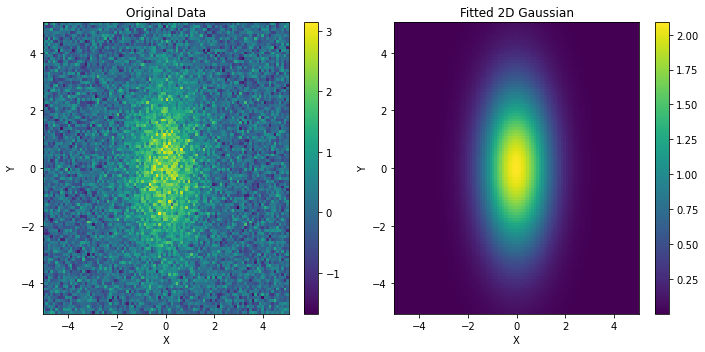

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

def gaussian_2d(xy, amplitude, x_mean, y_mean, x_std, y_std):
    x, y = xy
    return amplitude * np.exp(-((x - x_mean) ** 2 / (2 * x_std ** 2) + (y - y_mean) ** 2 / (2 * y_std ** 2)))

# Generate example data (you can replace this with your actual data)
np.random.seed(0)
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
data = gaussian_2d((X, Y), 2, 0, 0, 1, 2) + 0.5 * np.random.normal(size=X.shape)

# Flatten the grid data into 1D arrays
xdata = X.flatten()
ydata = Y.flatten()
zdata = data.flatten()

# Initial guess for parameters (amplitude, x_mean, y_mean, x_std, y_std)
initial_guess = [1, 0, 0, 1, 1]

# Fit the 2D Gaussian to the data using curve_fit from SciPy
best_fit_params, _ = curve_fit(gaussian_2d, (xdata, ydata), zdata, p0=initial_guess)

# Extract the fitted parameters
amplitude_fit, x_mean_fit, y_mean_fit, x_std_fit, y_std_fit = best_fit_params

print("Fitted Parameters:")
print(f"Amplitude: {amplitude_fit}")
print(f"x_mean: {x_mean_fit}")
print(f"y_mean: {y_mean_fit}")
print(f"x_std: {x_std_fit}")
print(f"y_std: {y_std_fit}")

# Create the fitted 2D Gaussian using the best-fit parameters
fitted_data = gaussian_2d((X, Y), *best_fit_params)

# Plot the original data and the fitted Gaussian
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pcolormesh(X, Y, data)
plt.title("Original Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(X, Y, fitted_data)
plt.title("Fitted 2D Gaussian")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar()

plt.tight_layout()
plt.show()


In [106]:
def weighted_correlation(x, y, wx, wy):
    mx = np.sum(wx * x) / np.sum(wx)
    my = np.sum(wy * y) / np.sum(wy)
    sx = np.sum(wx * (x - mx)**2) / np.sum(wx)
    sy = np.sum(wy * (y - my)**2) / np.sum(wy)
    sxy = np.sum(np.sqrt(wx * wy) * (x - mx) * (y - my)) / np.sum(np.sqrt(wx * wy))
    return sxy / np.sqrt(sx * sy)

def weighted_covariance(x, y, wx, wy):
    n = x.shape[0]
    mx = np.sum(wx * x) / np.sum(wx)
    my = np.sum(wy * y) / np.sum(wy)
    sxy = np.sum(np.sqrt(wx * wy) * (x - mx) * (y - my)) / np.sum(np.sqrt(wx * wy)) * n / (n - 1) #unbiased
    return sxy 

def weighted_variance(x, wx):
    n = x.shape[0]
    mx = np.sum(wx * x) / np.sum(wx)
    return np.sum(wx * (x - mx)**2) / np.sum(wx) * n / (n - 1) #unbiased

In [47]:
cf = pd.read_csv('data/coef_stat.csv', index_col=0)

In [131]:
### META REGRESSION ###
from pymare import meta_regression
lmb_mres = meta_regression(cf['lmb'], cf['lmb_V'])
rho_mres = meta_regression(cf['rho'], cf['rho_V'])
lm, km = lmb_mres.to_df()['estimate'].item(), rho_mres.to_df()['estimate'].item()
ls = weighted_variance(cf['lmb'], 1/cf['lmb_V'])
ks = weighted_variance(cf['rho'], 1/cf['rho_V'])
sxy = weighted_covariance(x, y, wx, wy)

n = cf.shape[0]
mu = np.array([lm, km])
S = np.array([[ls, sxy], 
              [sxy, ks]])

In [161]:
# t squared test from here https://en.wikipedia.org/wiki/Hotelling%27s_T-squared_distribution

def hotteling_t2_test(xnew, mu, S, n, alpha=0.05):
    from scipy.stats import chi2
    p = mu.shape[0]
    d = (xnew - mu) @ np.linalg.inv(S) @ (xnew - mu) #squared mahalanobis distance
    pval = 1 - chi2.cdf(d, p)
    verdict = 'Outlier!' if pval < alpha else 'Plausible!'
    return d, pval, verdict


In [162]:
cf

,lmb,rho,lmb_V,rho_V
0,886.172114,7.210702,337.381475,0.616362
1,819.462611,5.109104,560.754395,0.303367
2,1001.775191,6.872591,1327.924064,1.458862
3,950.092506,6.225108,437.576767,0.482874
4,870.038289,7.181494,417.252057,0.799929
5,961.552303,7.208850,474.940178,0.683761
6,1012.227949,11.840560,339.195750,3.665002
7,1000.695425,8.486069,619.090959,1.833783
8,834.854490,5.532559,482.862529,0.385021
9,863.088040,5.419356,674.633528,0.424057


In [165]:
for i, row in cf.iterrows():
    xnew = np.array([row['lmb'], row['rho']])
    print(i, hotteling_t2_test(xnew, mu, S, n, alpha=0.05))

0 (2.657251599343023, 0.2648409558765492, 'Plausible!')
1 (1.9508374270136386, 0.3770344510903071, 'Plausible!')
2 (2.5459906158275616, 0.27999170313467725, 'Plausible!')
3 (1.1624616004446973, 0.5592096674437974, 'Plausible!')
4 (3.827184939788201, 0.14754936667235974, 'Plausible!')
5 (0.3692949584210785, 0.8313973170375037, 'Plausible!')
6 (31.04754948581706, 1.811800147688558e-07, 'Outlier!')
7 (2.526255396202087, 0.2827682283164912, 'Plausible!')
8 (1.4696794417899428, 0.47958231984014577, 'Plausible!')
9 (0.7907297416833562, 0.6734342778842297, 'Plausible!')
